### ToDo

* Function get_src_dst_vertices(test_image) should take test_image size as parameter instead of the image itself!

Finding corners in calibration image
corners.size: 108
len(corners): 54


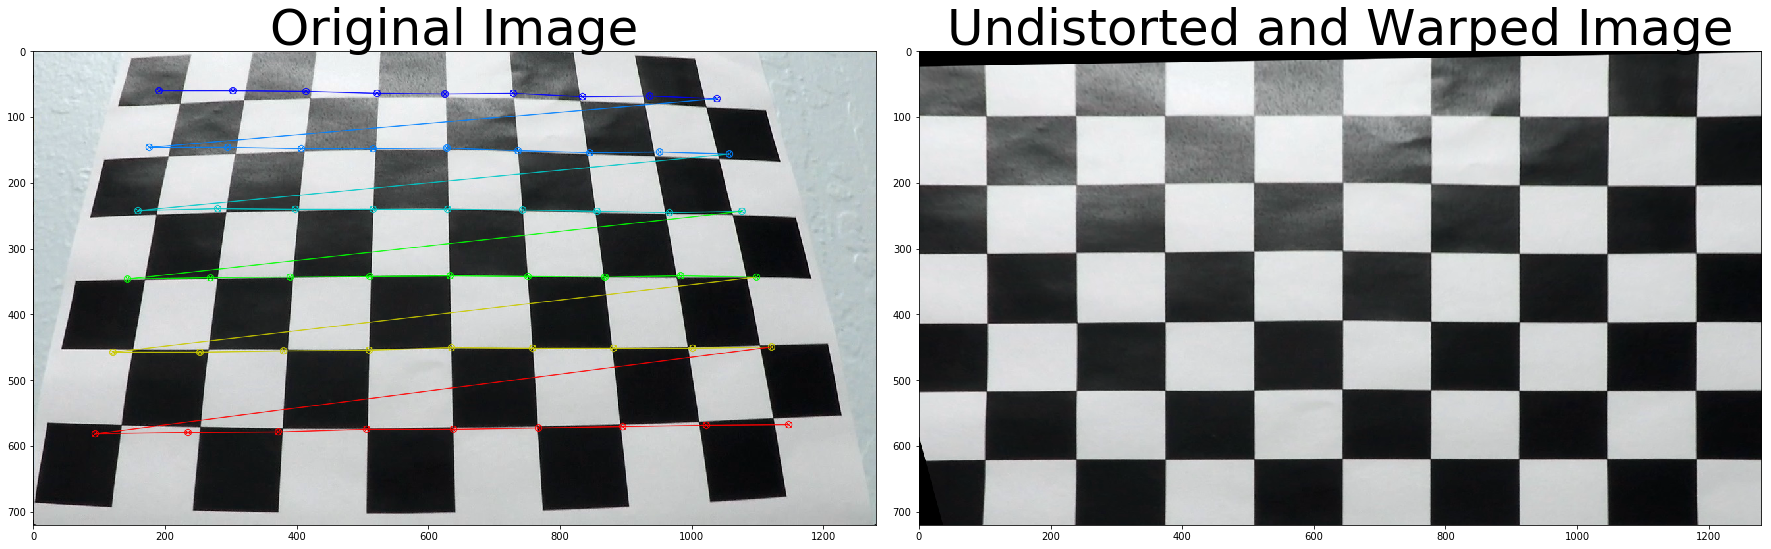

In [4]:
import pickle
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from camera_calibration import undistort_image

### Perspective transform for a calibration image ###

def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    img_undistorted = undistort_image(img, mtx, dist, plot_images=False)
    
    # 2) Convert to grayscale
    gray = cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2GRAY)
    
    # 3) Find the chessboard corners
    print("Finding corners in calibration image")
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # 4) If corners found: 
    if ret == True:
        print("corners.size: {}".format(corners.size))
        print("len(corners): {}".format(len(corners)))
        
        # a) draw corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
             #Note: you could pick any four of the detected corners 
             # as long as those four corners define a rectangle
             #One especially smart way to do this would be to use four well-chosen
             # corners that were automatically detected during the undistortion steps
             #We recommend using the automatic detection of corners in your code
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
         
        # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        offset = 100
        img_size = (gray.shape[1], gray.shape[0])
        dst = np.float32([[offset, offset],
                         [img_size[0]-offset, offset],
                         [img_size[0]-offset, img_size[1]-offset],
                         [offset, img_size[1]-offset]])
        
        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)

        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(img_undistorted, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        print("Could not find chessboard corners!")
        M = None
        warped = np.copy(img) 
        
    return warped, M

# Read in the saved camera matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = pickle.load( open( "./camera_cal/calibration_results.p", "rb" ) )

# Read in an image
calib_img = cv2.imread('./camera_cal/calibration3.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

from_front, _ = corners_unwarp(calib_img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(calib_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(from_front)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


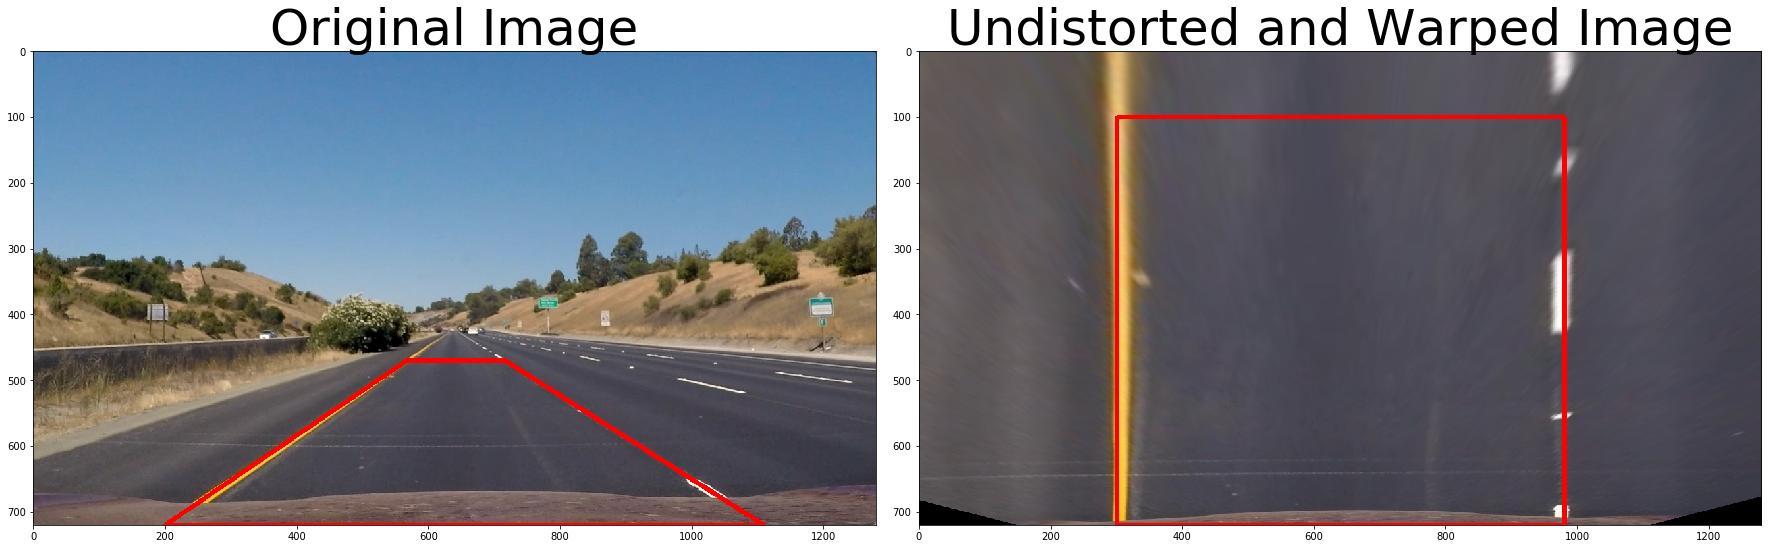

In [5]:
## Perspective transform for a test road image ###

def get_src_dst_vertices(img_size):
    
    #src = np.float32([[570, 470],[716, 470],[1012, 660],[290, 660]])
    # src = np.float32([[568, 470],[716, 470],[1012, 660],[290, 660]])
    src = np.float32([[567, 470],[717, 470],[1110, 720],[200, 720]])

    offset, mult = 100, 3    
    dst = np.float32([[mult * offset, offset],
                     [img_size[0] - mult * offset, offset],
                     [img_size[0] - mult * offset, img_size[1]],
                     [mult * offset, img_size[1]]])

    return src, dst

def warp_image_to_top_down_view(img, img_size, mtx, dist, perspective_M):

    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, perspective_M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

def get_perspective_transform(img, img_size, mtx, dist, src=None, dst=None):

    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)

    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, M_inv


# Read in the saved camera matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = pickle.load( open( "./camera_cal/calibration_results.p", "rb" ) )

# Read in an image
test_image = cv2.cvtColor(cv2.imread('./test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)

img_size = (test_image.shape[1], test_image.shape[0])
src, dst = get_src_dst_vertices(img_size)

img_undistorted = undistort_image(test_image, mtx, dist, plot_images=False)
top_down, perspective_M = get_perspective_transform(img_undistorted, img_size, mtx, dist, src, dst)

pts = np.array(src, np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(test_image, [pts], True, (255, 0, 0), 5)

pts = np.array(dst, np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(top_down, [pts], True, (255, 0, 0), 5)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

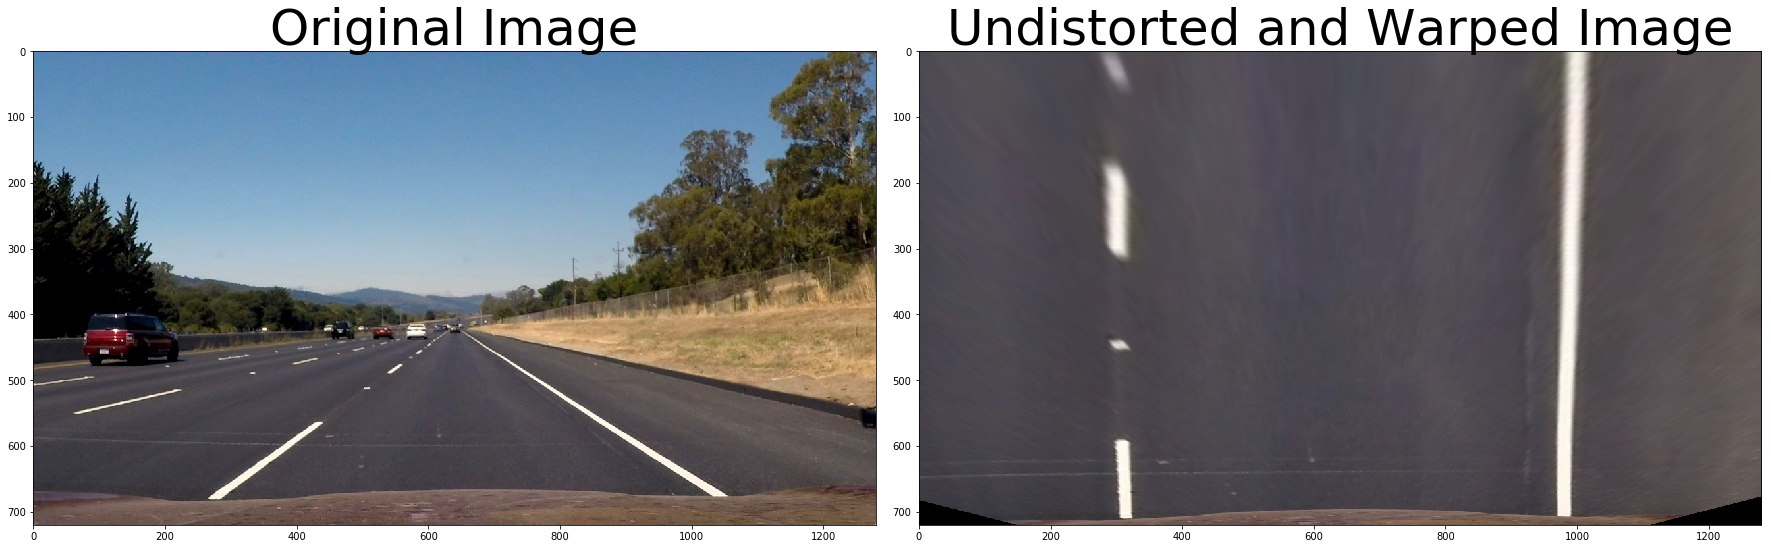

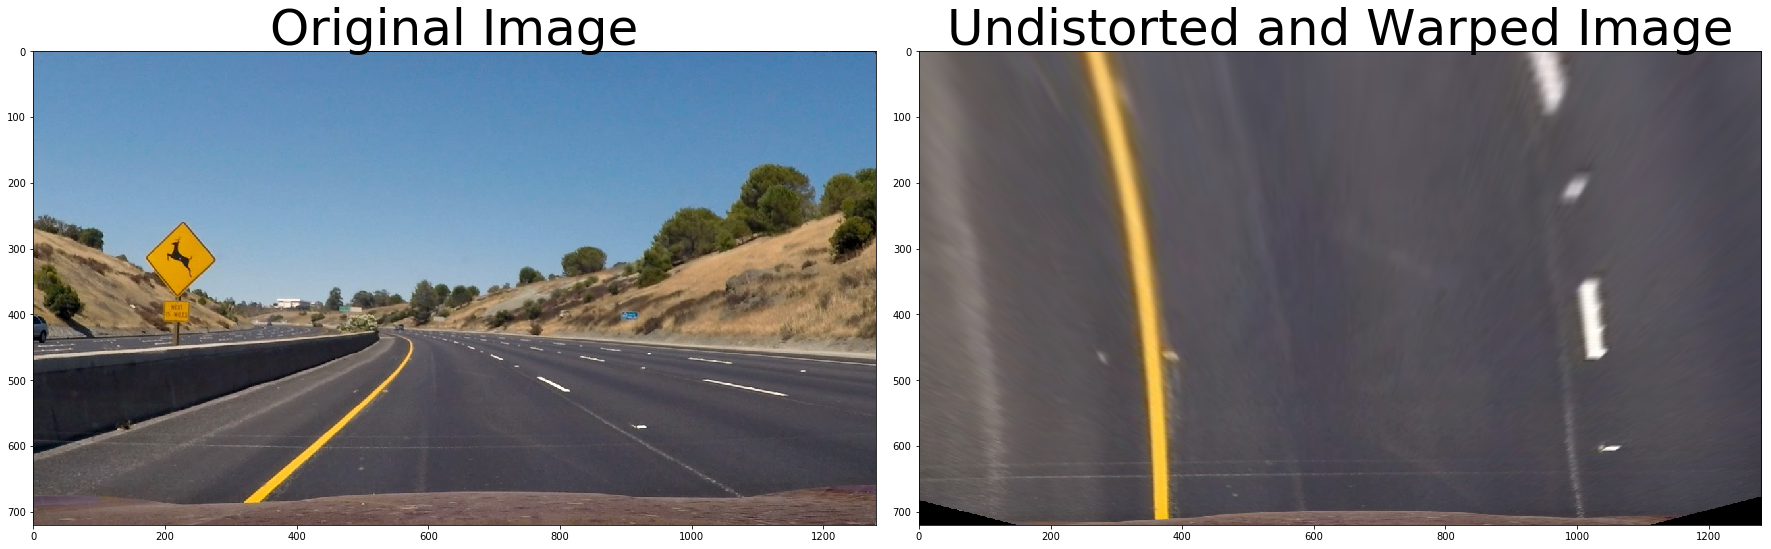

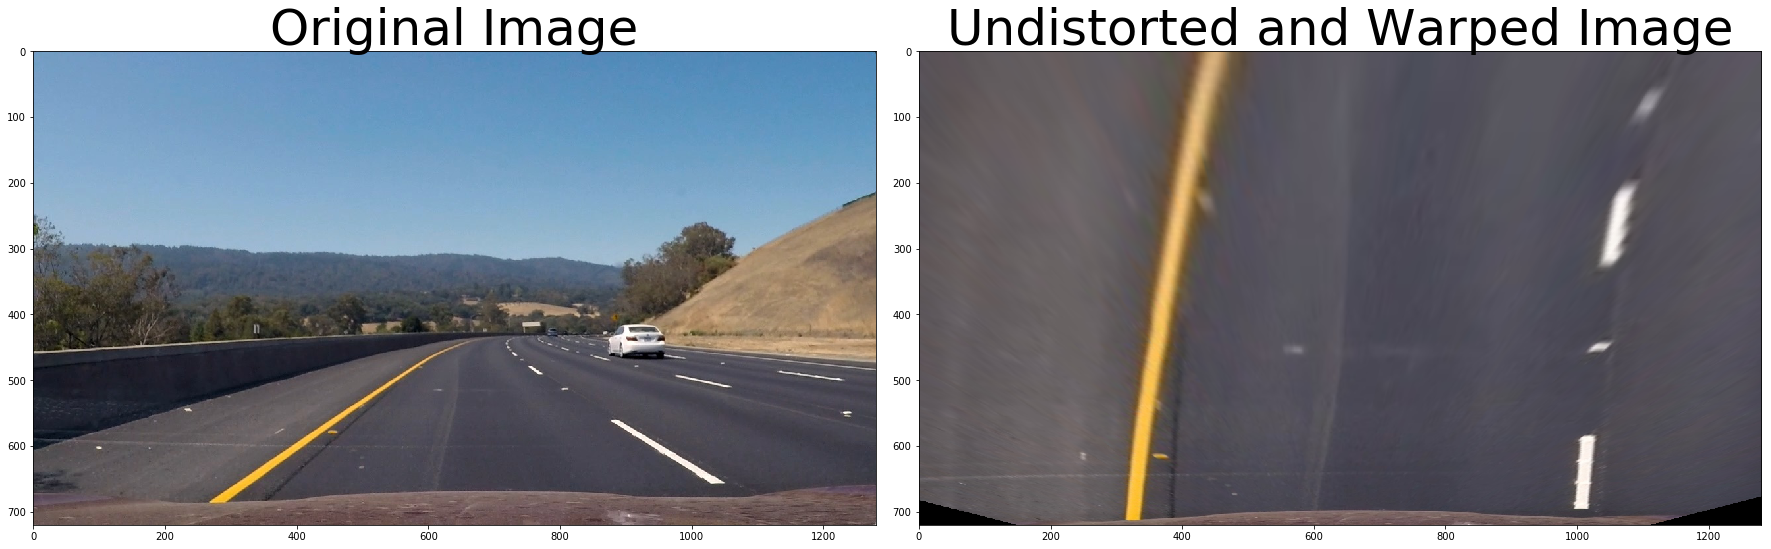

In [6]:
### Image with straight lane-lines ###
# test2.jpg
test_image = cv2.cvtColor(cv2.imread('./test_images/straight_lines2.jpg'), cv2.COLOR_BGR2RGB)
img_undistorted = undistort_image(test_image, mtx, dist, plot_images=False)
top_down = warp_image_to_top_down_view(img_undistorted, img_size, mtx, dist, perspective_M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Images with curved lane-lines ###
# test2.jpg
test_image = cv2.cvtColor(cv2.imread('./test_images/test2.jpg'), cv2.COLOR_BGR2RGB)
img_undistorted = undistort_image(test_image, mtx, dist, plot_images=False)
top_down = warp_image_to_top_down_view(img_undistorted, img_size, mtx, dist, perspective_M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# test3.jpg
test_image = cv2.cvtColor(cv2.imread('./test_images/test3.jpg'), cv2.COLOR_BGR2RGB)
img_undistorted = undistort_image(test_image, mtx, dist, plot_images=False)
top_down = warp_image_to_top_down_view(img_undistorted, img_size, mtx, dist, perspective_M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

